Dueling DQN Acrobot Environment
ME20B083
ME20B138

In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
from scipy.special import softmax

In [ ]:
import gym
env = gym.make('Acrobot-v1')
env.seed(0)
state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n
print("State shape:", state_shape)
print("Number of actions:", no_of_actions)
print("Sampled action:", env.action_space.sample())
print("----")
state = env.reset()
print("Initial state:", state)
print("----")
# Sample a random action
action = env.action_space.sample()
print("Random action:", action)
print("----")
# Take the sampled action in the environment
next_state, reward, done, info = env.step(action)
print("New state:", next_state)
print("Reward:", reward)
print("Episode done?", done)
print("Additional info:", info)
print("----")


State shape: 6
Number of actions: 3
Sampled action: 1
----
Initial state: [ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
Random action: 2
----
New state: [ 0.99996984 -0.0077642   0.9997182  -0.02373883 -0.25169677  0.31000718]
Reward: -1.0
Episode done? False
Additional info: {}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 1e-4               # learning rate
UPDATE_EVERY = 30       # how often to update the network (When Q target is present)


class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1_value = nn.Linear(state_size, fc1_units)
        self.fc2_value = nn.Linear(fc1_units, fc2_units)
        self.fc3_value = nn.Linear(fc2_units, 1)  # Output layer for value stream

        self.fc1_advantage = nn.Linear(state_size, fc1_units)
        self.fc2_advantage = nn.Linear(fc1_units, fc2_units)
        self.fc3_advantage = nn.Linear(fc2_units, action_size)  # Output layer for advantage stream

    def forward(self, state):
        x_value = F.relu(self.fc1_value(state))
        x_value = F.relu(self.fc2_value(x_value))
        value = self.fc3_value(x_value)

        x_advantage = F.relu(self.fc1_advantage(state))
        x_advantage = F.relu(self.fc2_advantage(x_advantage))
        advantage = self.fc3_advantage(x_advantage)

        # Combine value and advantage streams to get Q-values using Dueling DQN formula
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return q_values


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
class DuelingTutorialAgent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=1.0):


        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        # if random.random() > eps:
        #     return np.argmax(action_values.cpu().data.numpy())
        # else:
        #     return random.choice(np.arange(self.action_size))

        probabilities = softmax(action_values.cpu().data.numpy().flatten()/eps)
        return random.choices(population=range(len(probabilities)), weights=probabilities, k=1)[0]

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

In [ ]:

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def ddqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    all_scores = []
    scores_window = deque(maxlen=100)

    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        all_scores.append(score)

        eps = max(eps_end, eps_decay*eps)


        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=-110.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return all_scores



' Trial run to check if algorithm runs and saves the data '

In [ ]:
all_scores_type1 = []
seeds = [10, 18, 36, 42, 85]
for i in seeds:
  begin_time = datetime.datetime.now()
  env.reset()
  env.seed(i)
  agent = DuelingTutorialAgent(state_size=state_shape,action_size = action_shape,seed = i)
  all_scores = ddqn()
  all_scores_type1.append(all_scores)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 100	Average Score: -165.43
Episode 200	Average Score: -118.46
Episode 253	Average Score: -108.52
Environment solved in 253 episodes!	Average Score: -108.52
Episode 100	Average Score: -154.71
Episode 200	Average Score: -116.91
Episode 241	Average Score: -109.97
Environment solved in 241 episodes!	Average Score: -109.97
Episode 100	Average Score: -161.62
Episode 200	Average Score: -117.48
Episode 245	Average Score: -109.58
Environment solved in 245 episodes!	Average Score: -109.58
Episode 100	Average Score: -255.95
Episode 200	Average Score: -139.77
Episode 299	Average Score: -109.93
Environment solved in 299 episodes!	Average Score: -109.93
Episode 100	Average Score: -186.97
Episode 200	Average Score: -114.03
Episode 300	Average Score: -112.28
Episode 313	Average Score: -109.99
Environment solved in 313 episodes!	Average Score: -109.99


In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 1e-4               # learning rate
UPDATE_EVERY = 10      # how often to update the network (When Q target is present)


class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1_value = nn.Linear(state_size, fc1_units)
        self.fc2_value = nn.Linear(fc1_units, fc2_units)
        self.fc3_value = nn.Linear(fc2_units, 1)  # Output layer for value stream

        self.fc1_advantage = nn.Linear(state_size, fc1_units)
        self.fc2_advantage = nn.Linear(fc1_units, fc2_units)
        self.fc3_advantage = nn.Linear(fc2_units, action_size)  # Output layer for advantage stream

    def forward(self, state):
      x_value = F.relu(self.fc1_value(state))
      x_value = F.relu(self.fc2_value(x_value))
      value = self.fc3_value(x_value)
      x_advantage = F.relu(self.fc1_advantage(state))
      x_advantage = F.relu(self.fc2_advantage(x_advantage))
      advantage = self.fc3_advantage(x_advantage)

      # Combine value and advantage streams to get Q-values using Dueling DQN Type-2 formula
      q_values = value + (advantage - advantage.max(dim=1, keepdim=True)[0])

      return q_values

In [ ]:
all_scores_type2 = []
seeds = [10, 18, 36, 42, 85]
for i in seeds:
  begin_time = datetime.datetime.now()
  env.reset()
  env.seed(i)
  agent = DuelingTutorialAgent(state_size=state_shape,action_size = action_shape,seed = i)
  all_scores = ddqn()
  all_scores_type2.append(all_scores)

Episode 100	Average Score: -177.02
Episode 200	Average Score: -114.57
Episode 224	Average Score: -109.84
Environment solved in 224 episodes!	Average Score: -109.84
Episode 100	Average Score: -202.53
Episode 200	Average Score: -113.71
Episode 221	Average Score: -109.97
Environment solved in 221 episodes!	Average Score: -109.97
Episode 100	Average Score: -196.42
Episode 200	Average Score: -115.31
Episode 244	Average Score: -109.89
Environment solved in 244 episodes!	Average Score: -109.89
Episode 100	Average Score: -263.02
Episode 200	Average Score: -121.60
Episode 225	Average Score: -109.39
Environment solved in 225 episodes!	Average Score: -109.39
Episode 100	Average Score: -210.63
Episode 200	Average Score: -123.55
Episode 228	Average Score: -109.93
Environment solved in 228 episodes!	Average Score: -109.93


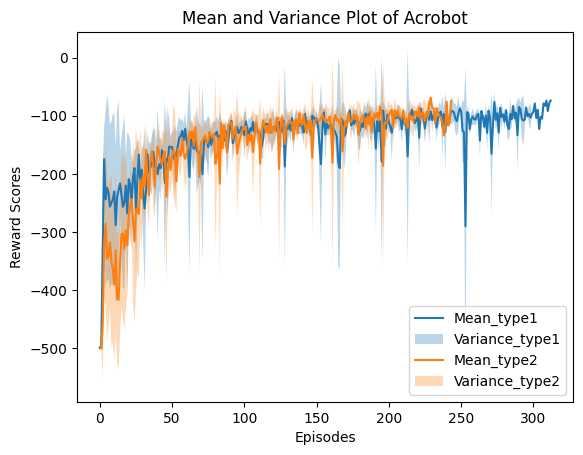

In [ ]:

import statistics
mean_list1 = []
variance_list1 = []

for i in range(max(len(lst) for lst in all_scores_type1)):
    numbers = []
    for lst in all_scores_type1:
        if i < len(lst):
            numbers.append(lst[i])
    if len(numbers) > 1:  # Check if there are at least two elements
        mean = sum(numbers) / len(numbers)
        variance = statistics.variance(numbers)
        mean_list1.append(mean)
        variance_list1.append(variance)
    elif len(numbers) == 1:  # If there's only one element, set variance to 0
        mean_list1.append(numbers[0])
        variance_list1.append(0)

# Plotting
x = range(len(mean_list1))
plt.plot(x, mean_list1, label='Mean_type1')
plt.fill_between(x, [m - v ** 0.5 for m, v in zip(mean_list1, variance_list1)],
                 [m + v ** 0.5 for m, v in zip(mean_list1, variance_list1)],
                 alpha=0.3, label='Variance_type1')





mean_list2 = []
variance_list2 = []

for i in range(max(len(lst) for lst in all_scores_type2)):
    numbers = []
    for lst in all_scores_type2:
        if i < len(lst):
            numbers.append(lst[i])
    if len(numbers) > 1:
        mean = sum(numbers) / len(numbers)
        variance = statistics.variance(numbers)
        mean_list2.append(mean)
        variance_list2.append(variance)
    elif len(numbers) == 1:
        mean_list2.append(numbers[0])
        variance_list2.append(0)

# Plotting
x = range(len(mean_list2))
plt.plot(x, mean_list2, label='Mean_type2')
plt.fill_between(x, [m - v ** 0.5 for m, v in zip(mean_list2, variance_list2)],
                 [m + v ** 0.5 for m, v in zip(mean_list2, variance_list2)],
                 alpha=0.3, label='Variance_type2')
plt.xlabel('Episodes')
plt.ylabel('Reward Scores')
plt.title('Mean and Variance Plot of Acrobot')
plt.legend()
plt.show()